In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
# Libraries for calculation
import pandas as pd
import numpy as np
import os

# Libraries for plotting
import seaborn as sns 
import matplotlib.pyplot as plt 

# Keras
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.utils.np_utils import to_categorical
from keras.models import Sequential

# Sklearn
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split 


In [3]:
# Data Loading
train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Data preprocessing before model training
y_train = train['label'].astype('float32')
X_train = train.drop(['label'], axis=1).astype('int32')
X_test = test.astype('float32')
X_train.shape, y_train.shape, X_test.shape

# Scale pixel by divind by 255
X_train = X_train/255
X_test = X_test/255

X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)

y_train = to_categorical(y_train, num_classes = 10)

In [5]:
# Split train data into train and validation data
X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train,test_size=.2,random_state=1)

In [15]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [16]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

In [23]:
# Model Building
model = Sequential()

#Layer 1
model.add(Conv2D(filters = 512, kernel_size = (5,5),padding = 'Same', 
                 activation ='selu', input_shape = (28,28,1)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

#Layer 2
model.add(Conv2D(filters = 256, kernel_size = (5,5),padding = 'Same', 
                 activation ='selu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

#Layer 3
model.add(Conv2D(filters = 256, kernel_size = (3,3),padding = 'Same', 
                 activation ='selu'))
model.add(BatchNormalization())

#Layer 4
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='selu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation = "selu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation = "selu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 28, 28, 512)       13312     
_________________________________________________________________
batch_normalization_24 (Batc (None, 28, 28, 512)       2048      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 14, 14, 512)       0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 14, 14, 512)       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 14, 14, 256)       3277056   
_________________________________________________________________
batch_normalization_25 (Batc (None, 14, 14, 256)       1024      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 7, 7, 256)        

In [ ]:
model.compile(optimizer = keras.optimizers.SGD(learning_rate= 0.01),loss = 'categorical_crossentropy',metrics = ['accuracy'])
history = model.fit(X_train, y_train, epochs = 40, batch_size = 1000, validation_data = (X_valid, y_valid))

Epoch 1/40
34/34 [==============================] - 22s 629ms/step - loss: 2.1601 - accuracy: 0.4844 - val_loss: 1.3189 - val_accuracy: 0.5786
Epoch 2/40
34/34 [==============================] - 22s 649ms/step - loss: 0.8558 - accuracy: 0.7421 - val_loss: 2.6262 - val_accuracy: 0.1918
Epoch 3/40
34/34 [==============================] - 21s 620ms/step - loss: 0.6023 - accuracy: 0.8145 - val_loss: 4.0969 - val_accuracy: 0.1144
Epoch 4/40
34/34 [==============================] - 21s 612ms/step - loss: 0.4973 - accuracy: 0.8449 - val_loss: 4.5477 - val_accuracy: 0.1138
Epoch 5/40
34/34 [==============================] - 21s 617ms/step - loss: 0.4245 - accuracy: 0.8691 - val_loss: 4.8239 - val_accuracy: 0.1149
Epoch 6/40
34/34 [==============================] - 21s 629ms/step - loss: 0.3811 - accuracy: 0.8849 - val_loss: 4.3094 - val_accuracy: 0.1333
Epoch 7/40
34/34 [==============================] - 21s 626ms/step - loss: 0.3410 - accuracy: 0.8954 - val_loss: 3.8639 - val_accuracy: 0.1677

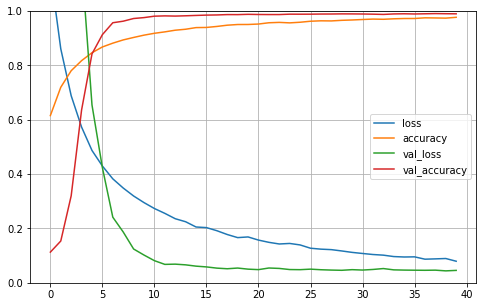

In [9]:
# Plotting validation and accuracy curves 
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [48]:
# Use Model to predict on test data
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)

In [49]:
# Save prediction in .csv as suggested
prediction = pd.DataFrame({'ImageId': list(range(1, len(y_pred)+1)), 'Label': y_pred})
prediction.to_csv("./submission.csv",index=False)